In [1]:
from tensorboard.backend.event_processing import event_accumulator

import matplotlib.pyplot as plt
from matplotlib.axis import Axis

from tabulate import tabulate
import seaborn as sns
from tqdm import tqdm

from typing import Literal, List
import warnings
import os

warnings.filterwarnings('ignore')
%cd ~/GitLab/bev2seg_2/

MODELS_PATH = "./models"

COLOR_PALETTE = [
    "#FF0064",
    "#FF62A0",
    "#0277BD",
    "#2AB0D2",
    "#7700A0",
    "#B200EF",
    "#00A032",
    "#03FF52",
    "#FF9800",
    "#FFB03B",
]


/home/VICOMTECH/agarciaj/GitLab/bev2seg_2


In [4]:
def load_models_data(models_path:str, 
    selected_type:Literal["bev", "nu"], 
    scalar_tags:List[str]=["eval/loss", "eval/mean_accuracy", "eval/mean_iou", "eval/overall_accuracy", "train/learning_rate", "train/loss"]
    ) -> dict:
    # SCALAR TAGS:
    # "eval/loss", "eval/mean_accuracy", "eval/mean_iou", "eval/overall_accuracy", "eval/runtime", "eval/samples_per_second", "eval/steps_per_second"
    # "train/epoch", "train/grad_norm", "train/learning_rate", "train/loss", "train/total_flos", "train/train_loss", "train/train_runtime", "train/train_samples_per_second", "train/train_steps_per_second"

    models_path     = "./models"
    map_selection   = { "bev": "segformer_bev", "nu": "segformer_nu_formatted" }
    runs_path = os.path.join(models_path, map_selection[selected_type], "runs")

    models_data = {}

    # Iterar sobre subcarpetas (cada subcarpeta es un modelo)
    for model_name in os.listdir(runs_path):
        model_path = os.path.join(runs_path, model_name)
        if not os.path.isdir(model_path):
            continue

        # Buscar archivos de eventos en la subcarpeta
        for root, _, files in os.walk(model_path):
            for file in files:
                if file.startswith("events.out.tfevents"):
                    event_file = os.path.join(root, file)
                    ea = event_accumulator.EventAccumulator(event_file)
                    ea.Reload()

                    for st in ea.Tags()["scalars"]:
                        if st in scalar_tags:
                            scalar_events = ea.Scalars(st)
                            steps = [e.step for e in scalar_events]
                            values = [e.value for e in scalar_events]
                            if model_name not in models_data:
                                models_data[model_name] = {}
                            models_data[model_name][st] = (steps, values)
    show_models_data(models_data, selected_type=selected_type)
    return models_data

def show_models_data(models_data:dict, selected_type:str = ""):
    names = list(models_data.keys())
    tags = [list(models_data[n].keys()) for n in names]
    data = [ (n, t) for n, t in zip(names, tags)]
    inf = tabulate(data, headers=['Model name', 'Tags'])
    print(f"LOADED DATA [{selected_type}]:\n {inf}\n")


def plot_train_vs_eval_loss(models_data, model_name, label_name:str=None, colors:tuple = (COLOR_PALETTE[0], COLOR_PALETTE[7]), ax:Axis = None):
    label_name = model_name if label_name is None else label_name
    
    for tag, (steps, vals) in models_data[model_name].items():
        if tag == "train/loss":
            if ax is not None:
                ax.plot(steps, vals, label=f"{label_name} train", color=colors[0])
            else:
                plt.plot(steps, vals, label=f"{label_name} train", color=colors[0])
        if tag == "eval/loss":
            if ax is not None:
                ax.plot(steps, vals, label=f"{label_name} eval", color=colors[1])
            else:
                plt.plot(steps, vals, label=f"{label_name} eval", color=colors[1])

def plot_mIoU(models_data, model_name, label_name:str=None, color = COLOR_PALETTE[0], ax:Axis = None):
    label_name = model_name if label_name is None else label_name

    for tag, (steps, vals) in models_data[model_name].items():
        if tag == "eval/mean_iou":
            if ax is not None:
                ax.plot(steps, vals, label=f"{label_name}", color=color)
            else:
                plt.plot(steps, vals, label=f"{label_name}", color=color)

In [5]:
bev_logs = load_models_data(MODELS_PATH, "bev")
nu_logs = load_models_data(MODELS_PATH, "nu")

2025-05-06 11:56:08.744868: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-05-06 11:56:09.167703: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-05-06 11:56:09.593142: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1746525369.941223  733761 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1746525370.039070  733761 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1746525370.810954  733761 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linkin

LOADED DATA [bev]:
 Model name              Tags
----------------------  ------------------------------------------------------------------------------------------------------------------
raw2bevseg_mit-b2_v0.4  ['train/loss', 'train/learning_rate', 'eval/loss', 'eval/mean_iou', 'eval/mean_accuracy', 'eval/overall_accuracy']
raw2bevseg_mit-b0_v0.3  ['train/loss', 'train/learning_rate', 'eval/loss', 'eval/mean_iou', 'eval/mean_accuracy', 'eval/overall_accuracy']
raw2bevseg_mit-b2_v0.3  ['train/loss', 'train/learning_rate', 'eval/loss', 'eval/mean_iou', 'eval/mean_accuracy', 'eval/overall_accuracy']
raw2bevseg_mit-b0_v0.1  ['train/loss', 'train/learning_rate', 'eval/loss', 'eval/mean_iou', 'eval/mean_accuracy', 'eval/overall_accuracy']
raw2bevseg_mit-b4_v0.1  ['train/loss', 'train/learning_rate', 'eval/loss', 'eval/mean_iou', 'eval/mean_accuracy', 'eval/overall_accuracy']
raw2bevseg_mit-b0_v0.2  ['train/loss', 'train/learning_rate', 'eval/loss', 'eval/mean_iou', 'eval/mean_accuracy', 'ev

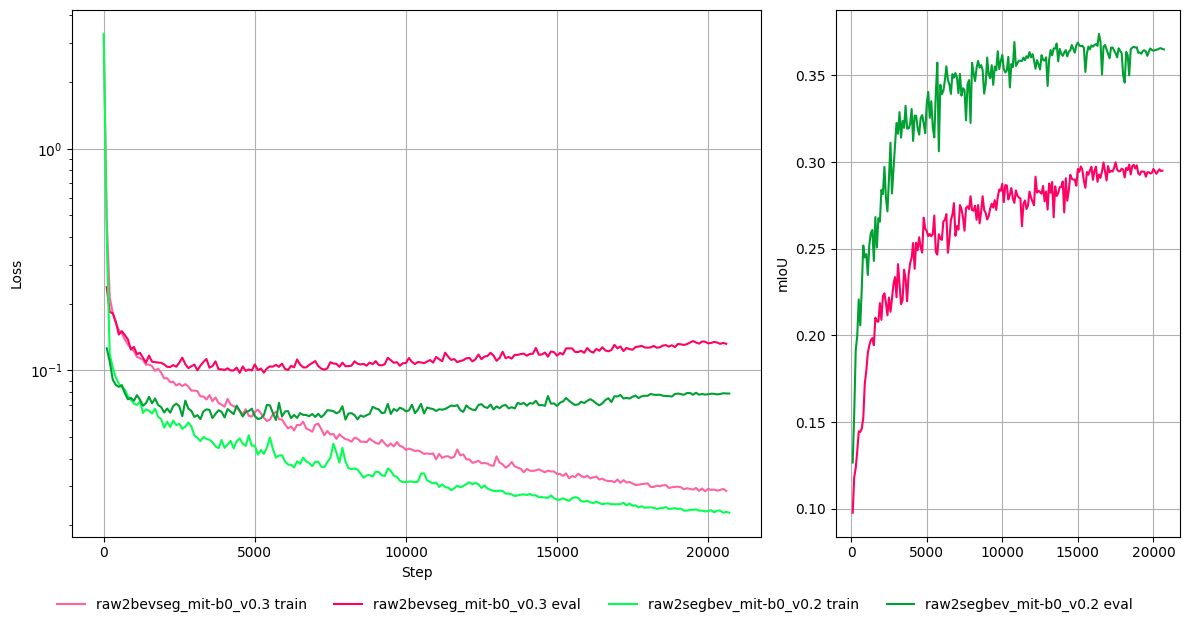

In [9]:
# WITHOUT DATA AUGMENTATION
fig, axes = plt.subplots(1, 2, sharex=True, sharey=False, figsize=(12, 6),gridspec_kw={'width_ratios': [2, 1]} )
plot_train_vs_eval_loss(bev_logs, "raw2bevseg_mit-b0_v0.3", colors = (COLOR_PALETTE[1], COLOR_PALETTE[0]), ax=axes[0])
plot_train_vs_eval_loss(nu_logs, "raw2segbev_mit-b0_v0.2", colors = (COLOR_PALETTE[7], COLOR_PALETTE[6]), ax=axes[0])
plot_mIoU(bev_logs, "raw2bevseg_mit-b0_v0.3", color = COLOR_PALETTE[0], ax=axes[1])
plot_mIoU(nu_logs, "raw2segbev_mit-b0_v0.2", color = COLOR_PALETTE[6], ax=axes[1])

handles, labels = axes[0].get_legend_handles_labels()
fig.legend(handles, labels,loc='lower center',ncol=4,bbox_to_anchor=(0.5, -0.05),frameon=False)

axes[0].set_xlabel("Step")
axes[0].set_ylabel("Loss")
axes[0].set_yscale('log')
axes[0].grid(True)

axes[1].set_ylabel("mIoU")
axes[1].grid(True)

plt.tight_layout()
plt.show()

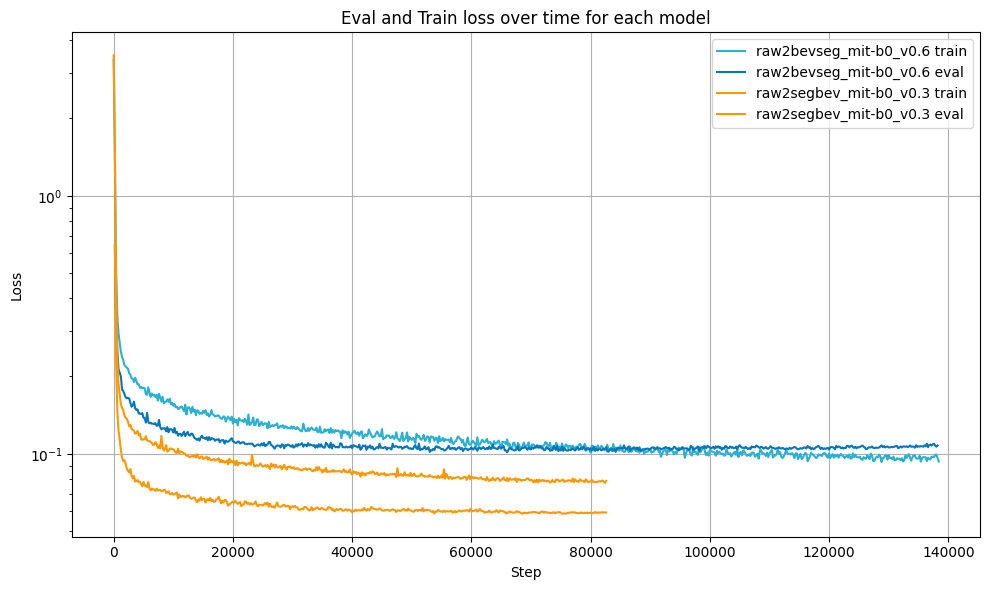

In [10]:
# WITH DATA AUGMENTATION
plt.figure(figsize=(10, 6))

#plot_train_vs_eval_loss(bev_logs, "raw2bevseg_mit-b0_v0.5", colors = (COLOR_PALETTE[5], COLOR_PALETTE[4]))
plot_train_vs_eval_loss(bev_logs, "raw2bevseg_mit-b0_v0.6", colors = (COLOR_PALETTE[3], COLOR_PALETTE[2]))
plot_train_vs_eval_loss(nu_logs, "raw2segbev_mit-b0_v0.3", colors = (COLOR_PALETTE[8], COLOR_PALETTE[8]))

plt.xlabel("Step")
plt.ylabel("Loss")
plt.yscale('log')
plt.title(f"Eval and Train loss over time for each model")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

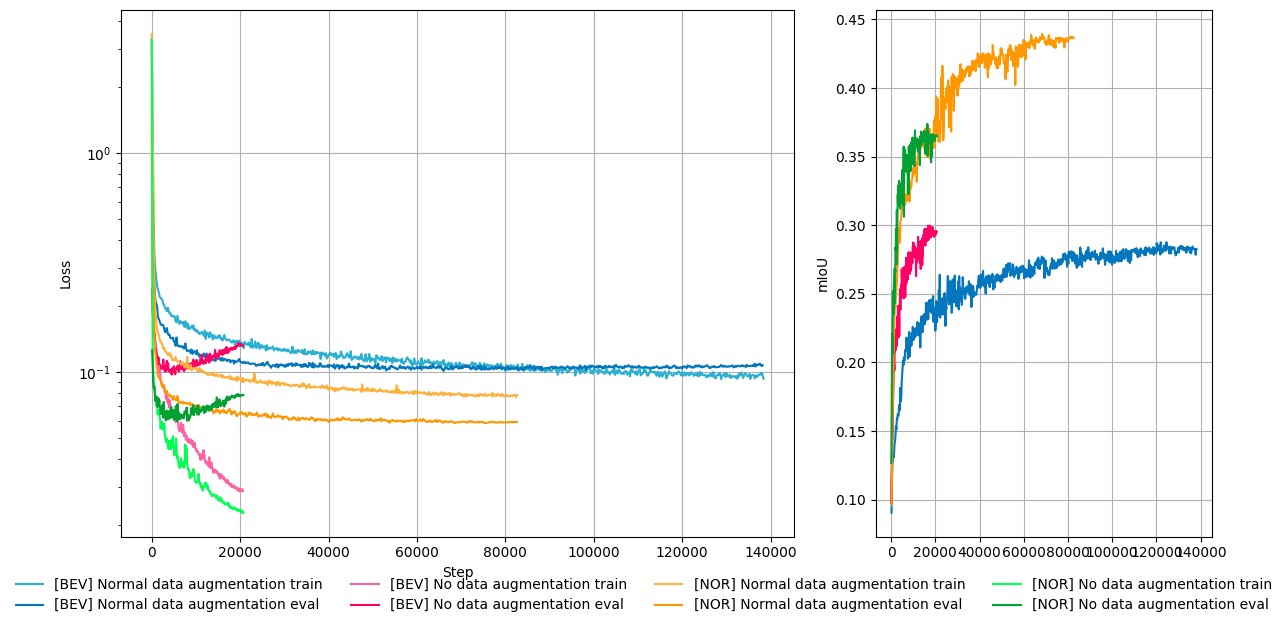

In [8]:
# DATA AUGMENTATION COMP
fig, axes = plt.subplots(1, 2, sharex=True, sharey=False, figsize=(12, 6),gridspec_kw={'width_ratios': [2, 1]} )

# RAW -> BEV -> SEG
plot_train_vs_eval_loss(bev_logs, "raw2bevseg_mit-b0_v0.6", label_name="[BEV] Normal data augmentation", colors = [COLOR_PALETTE[3], COLOR_PALETTE[2]], ax=axes[0])
plot_mIoU(bev_logs, "raw2bevseg_mit-b0_v0.6", label_name="[BEV] Normal data augmentation", color = COLOR_PALETTE[2], ax=axes[1])
# plot_train_vs_eval_loss(bev_logs, "raw2bevseg_mit-b0_v0.5", label_name="[BEV] Extrinsic data augmentation", colors = [COLOR_PALETTE[5], COLOR_PALETTE[4]], ax=axes[0])
# plot_mIoU(bev_logs, "raw2bevseg_mit-b0_v0.5", label_name="[BEV] Extrinsic data augmentation", color = COLOR_PALETTE[4], ax=axes[1])
plot_train_vs_eval_loss(bev_logs, "raw2bevseg_mit-b0_v0.3", label_name="[BEV] No data augmentation", colors = [COLOR_PALETTE[1], COLOR_PALETTE[0]], ax=axes[0])
plot_mIoU(bev_logs, "raw2bevseg_mit-b0_v0.3", label_name="[BEV] No data augmentation", color = COLOR_PALETTE[0], ax=axes[1])

# RAW -> SEG -> BEV
plot_train_vs_eval_loss(nu_logs, "raw2segbev_mit-b0_v0.3", label_name="[NOR] Normal data augmentation", colors = (COLOR_PALETTE[9], COLOR_PALETTE[8]), ax=axes[0])
plot_mIoU(nu_logs, "raw2segbev_mit-b0_v0.3", label_name="[NOR] Normal data augmentation", color = COLOR_PALETTE[8], ax=axes[1])
plot_train_vs_eval_loss(nu_logs, "raw2segbev_mit-b0_v0.2", label_name="[NOR] No data augmentation", colors = (COLOR_PALETTE[7], COLOR_PALETTE[6]), ax=axes[0])
plot_mIoU(nu_logs, "raw2segbev_mit-b0_v0.2", label_name="[NOR] No data augmentation", color = COLOR_PALETTE[6], ax=axes[1])
# plot_train_vs_eval_loss(nu_logs, "raw2segbev_mit-b0_v0.4", label_name="[NOR] Merging labels (no data aug)", colors = (COLOR_PALETTE[5], COLOR_PALETTE[4]), ax=axes[0])
# plot_mIoU(nu_logs, "raw2segbev_mit-b0_v0.4", label_name="[NOR] Merging labels (no data aug)", color = COLOR_PALETTE[4], ax=axes[1])


handles, labels = axes[0].get_legend_handles_labels()
fig.legend(handles, labels,loc='lower center',ncol=4,bbox_to_anchor=(0.5, -0.05),frameon=False)

axes[0].set_xlabel("Step")
axes[0].set_ylabel("Loss")
axes[0].set_yscale('log')
axes[0].grid(True)

axes[1].set_ylabel("mIoU")
axes[1].grid(True)

plt.tight_layout()
plt.show()